In [10]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Dropout,
    LSTM, Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import scipy.signal as signal
import os
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Let's explore the WESAD dataset structure
import os

# Check the dataset structure
dataset_path = r'C:\Final Year\PROJECT\COGNITION\PREP\WESAD'
print("Dataset contents:")
for item in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, item)):
        print(f"📁 {item}/")
    else:
        print(f"📄 {item}")

# The WESAD dataset has subject folders (S2, S3, etc.)
subject_folders = [f for f in os.listdir(dataset_path) if f.startswith('S') and os.path.isdir(os.path.join(dataset_path, f))]
print(f"\nFound {len(subject_folders)} subject folders: {subject_folders}")

Dataset contents:
📁 S10/
📁 S11/
📁 S13/
📁 S14/
📁 S15/
📁 S16/
📁 S17/
📁 S2/
📁 S3/
📁 S4/
📁 S5/
📁 S6/
📁 S7/
📁 S8/
📁 S9/
📄 wesad_readme.pdf

Found 15 subject folders: ['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']


In [12]:
# Let's examine one subject's data
sample_subject = 'S2'
sample_path = os.path.join(dataset_path, sample_subject)
print(f"\nContents of {sample_subject}:")
for item in os.listdir(sample_path):
    print(f"  {item}")


Contents of S2:
  S2.pkl
  S2_E4_Data
  S2_quest.csv
  S2_readme.txt
  S2_respiban.txt


In [13]:
# Function to read and process WESAD data from .pkl files
def process_wesad_data(subject_id, dataset_path):
    """
    Process WESAD data for a specific subject from .pkl files
    Returns: X (features), y (stress levels as percentages 0-100)
    """
    subject_path = os.path.join(dataset_path, subject_id)
    
    # Read the data from .pkl file
    import pickle
    with open(os.path.join(subject_path, f'{subject_id}.pkl'), 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    # Extract signals and labels
    signals = data['signal']
    labels = data['label']
    
    # WESAD label meanings: 1=neutral, 2=stress, 3=amusement, 4=meditation
    # We'll use all states to create a stress level index
    # Stress level mapping: 
    # Meditation (4) = 0-25% stress (lowest stress)
    # Neutral (1) = 25-50% stress (low stress)
    # Amusement (3) = 50-75% stress (medium stress) 
    # Stress (2) = 75-100% stress (highest stress)
    
    # Convert labels to stress percentage levels
    stress_levels = np.zeros_like(labels, dtype=float)
    
    # Map labels to stress percentages
    stress_levels[labels == 4] = 12.5   # Meditation: 0-25% (center at 12.5%)
    stress_levels[labels == 1] = 37.5   # Neutral: 25-50% (center at 37.5%)
    stress_levels[labels == 3] = 62.5   # Amusement: 50-75% (center at 62.5%)
    stress_levels[labels == 2] = 87.5   # Stress: 75-100% (center at 87.5%)
    
    # Extract relevant signals from chest sensor
    chest_data = signals['chest']
    
    # Get ACC data (3-axis accelerometer) - 700Hz
    acc = chest_data['ACC']
    
    # Get ECG data - 700Hz
    ecg = chest_data['ECG']
    
    # Get EDA data - 700Hz
    eda = chest_data['EDA']
    
    # Get temperature data - 700Hz (correct key name)
    temperature = chest_data['Temp']  # Note: 'Temp' not 'temp'
    
    # Get respiration data - 700Hz
    resp = chest_data['Resp']
    
    # Get EMG data - 700Hz (if available)
    emg = chest_data['EMG'] if 'EMG' in chest_data else np.array([])
    
    # Create feature matrix
    # We'll use 60-second windows with 50% overlap
    window_size_seconds = 60
    sampling_rate = 700  # Chest sensors sample at 700Hz
    window_size = window_size_seconds * sampling_rate
    
    X_list = []
    y_list = []
    
    # Process data using ECG as reference (highest sampling rate)
    for i in range(0, len(ecg) - window_size, window_size // 2):
        # Extract window for each signal
        ecg_window = ecg[i:i+window_size]
        eda_window = eda[i:i+window_size]
        temp_window = temperature[i:i+window_size]
        resp_window = resp[i:i+window_size]
        acc_window = acc[i:i+window_size]
        
        # Get the average stress level in this window
        window_stress_levels = stress_levels[i:i+window_size]
        if len(window_stress_levels) == 0:
            continue  # Skip if no data
            
        window_stress = np.mean(window_stress_levels)
        
        # Extract features from each signal
        features = extract_features(ecg_window, eda_window, temp_window, resp_window, acc_window)
        X_list.append(features)
        y_list.append(window_stress)
    
    return np.array(X_list), np.array(y_list)

def extract_features(ecg, eda, temp, resp, acc):
    """
    Extract features from physiological signals
    """
    features = []
    
    # ECG features
    features.extend([np.mean(ecg), np.std(ecg), np.min(ecg), np.max(ecg)])
    
    # Heart rate variability features
    try:
        # Use a more robust peak detection method
        peaks, _ = signal.find_peaks(ecg, height=np.mean(ecg) + 2*np.std(ecg), distance=100)
        if len(peaks) > 1:
            rr_intervals = np.diff(peaks) / 700  # Convert to seconds (ECG at 700Hz)
            features.extend([np.mean(rr_intervals), np.std(rr_intervals), 
                            np.min(rr_intervals), np.max(rr_intervals)])
        else:
            features.extend([0, 0, 0, 0])
    except:
        features.extend([0, 0, 0, 0])
    
    # EDA features
    features.extend([np.mean(eda), np.std(eda), np.max(eda) - np.min(eda),
                    np.percentile(eda, 25), np.percentile(eda, 75)])
    
    # Temperature features
    features.extend([np.mean(temp), np.std(temp), np.max(temp) - np.min(temp)])
    
    # Respiration features
    try:
        resp_peaks, _ = signal.find_peaks(resp, height=np.mean(resp) + 0.5*np.std(resp), distance=100)
        breathing_rate = len(resp_peaks) / (len(resp) / 700)  # Breaths per minute (resp at 700Hz)
        features.extend([np.mean(resp), np.std(resp), breathing_rate])
    except:
        features.extend([np.mean(resp), np.std(resp), 0])
    
    # Accelerometer features (magnitude and separate axes)
    acc_magnitude = np.linalg.norm(acc, axis=1)
    features.extend([np.mean(acc_magnitude), np.std(acc_magnitude),
                    np.percentile(acc_magnitude, 25), np.percentile(acc_magnitude, 75)])
    
    # Add features for each accelerometer axis
    for axis in range(3):
        features.extend([np.mean(acc[:, axis]), np.std(acc[:, axis])])
    
    return features

Processing WESAD data...
Processing S2...
Processed S2: (201, 29) features, (201,) stress levels
Processing S3...
Processed S3: (215, 29) features, (215,) stress levels
Processing S4...
Processed S4: (213, 29) features, (213,) stress levels
Processing S5...
Processed S5: (207, 29) features, (207,) stress levels
Processing S6...
Processed S6: (234, 29) features, (234,) stress levels
Processing S7...
Processed S7: (173, 29) features, (173,) stress levels
Processing S8...
Processed S8: (181, 29) features, (181,) stress levels
Processing S9...
Processed S9: (173, 29) features, (173,) stress levels
Processing S10...
Processed S10: (182, 29) features, (182,) stress levels
Processing S11...
Processed S11: (173, 29) features, (173,) stress levels
Processing S13...
Processed S13: (183, 29) features, (183,) stress levels
Processing S14...
Processed S14: (183, 29) features, (183,) stress levels
Processing S15...
Processed S15: (174, 29) features, (174,) stress levels
Processing S16...
Processed S

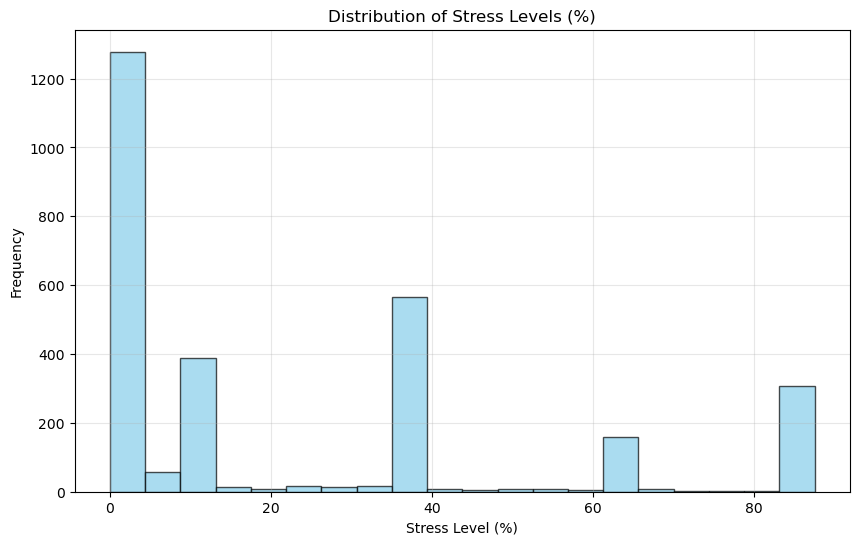

Processed data saved to X_features.npy and y_stress_levels.npy


In [14]:
# Process data for all subjects
print("Processing WESAD data...")
X_all = []
y_all = []

# List of subject folders (excluding S1 and S12 as they're not typically available)
subject_folders = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

for subject in subject_folders:
    try:
        print(f"Processing {subject}...")
        X, y = process_wesad_data(subject, dataset_path)
        if len(X) > 0 and len(y) > 0:
            X_all.append(X)
            y_all.append(y)
            print(f"Processed {subject}: {X.shape} features, {y.shape} stress levels")
        else:
            print(f"No data processed for {subject}")
    except Exception as e:
        print(f"Error processing {subject}: {e}")

# Check if we have any data before combining
if len(X_all) > 0:
    # Combine all subject data
    X = np.vstack(X_all)
    y = np.hstack(y_all)

    print(f"\nFinal dataset shape: {X.shape}")
    print(f"Stress level statistics:")
    print(f"Min: {np.min(y):.2f}%")
    print(f"Max: {np.max(y):.2f}%")
    print(f"Mean: {np.mean(y):.2f}%")
    print(f"Std: {np.std(y):.2f}%")
    
    # Display distribution of stress levels
    plt.figure(figsize=(10, 6))
    plt.hist(y, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution of Stress Levels (%)')
    plt.xlabel('Stress Level (%)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Save the processed data
    np.save('X_features.npy', X)
    np.save('y_stress_levels.npy', y)
    print("Processed data saved to X_features.npy and y_stress_levels.npy")
else:
    print("No data was processed. Please check the dataset structure.")

In [15]:
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Since we're doing regression (continuous stress levels), no need for class balancing
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"Reshaped training set: {X_train_reshaped.shape}")
print(f"Reshaped validation set: {X_val_reshaped.shape}")
print(f"Reshaped test set: {X_test_reshaped.shape}")

# Save the scaler for future use
joblib.dump(scaler, 'stress_scaler.pkl')
print("Feature scaler saved as 'stress_scaler.pkl'")

Training set: (1839, 29), (1839,)
Validation set: (460, 29), (460,)
Test set: (575, 29), (575,)
Reshaped training set: (1839, 29, 1)
Reshaped validation set: (460, 29, 1)
Reshaped test set: (575, 29, 1)
Feature scaler saved as 'stress_scaler.pkl'


In [16]:
# Improved CNN+LSTM hybrid model for stress prediction
def create_stress_cnn_lstm_model(input_shape):
    """
    Hybrid CNN + LSTM model for stress level prediction.
    CNN extracts local temporal features, LSTM captures long-term dependencies.
    Includes BatchNorm + Residual-style Dense layers for stability.
    """
    from tensorflow.keras.layers import BatchNormalization, Add

    model = Sequential([
        # First convolutional block
        Conv1D(64, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Second convolutional block
        Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Third convolutional block
        Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Feed into stacked LSTM
        LSTM(128, return_sequences=True),
        Dropout(0.4),

        LSTM(64, return_sequences=False),
        Dropout(0.3),

        # Fully connected dense layers (residual-style)
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='linear')  # Regression output
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # slightly lower LR for stability
        loss='mse',
        metrics=[
            'mae',
            tf.keras.metrics.RootMeanSquaredError(name='rmse')
        ]
    )

    return model


# Create model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
model = create_stress_cnn_lstm_model(input_shape)

# Summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_stress_cnn_lstm_model_v2.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 29, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 29, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 14, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 7, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 405,761 (1.55 MB)

 Trainable params: 404,481 (1.54 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [17]:
# Train the model
print("Starting model training...")
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping, model_checkpoint, lr_reducer],
    verbose=1
)

Starting model training...
Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1444.1426 - mae: 24.3415 - rmse: 37.9924
Epoch 1: val_loss improved from inf to 1357.13367, saving model to best_stress_cnn_lstm_model_v2.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 1443.7621 - mae: 24.3401 - rmse: 37.9875 - val_loss: 1357.1337 - val_mae: 23.1129 - val_rmse: 36.8393 - learning_rate: 5.0000e-04
Epoch 2/100
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1421.8591 - mae: 24.2478 - rmse: 37.7015
Epoch 2: val_loss improved from 1357.13367 to 1342.37939, saving model to best_stress_cnn_lstm_model_v2.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1420.6011 - mae: 24.2405 - rmse: 37.6851 - val_loss: 1342.3794 - val_mae: 23.0706 - val_rmse: 36.6385 - learning_rate: 5.0000e-04
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1441.4100 - mae: 24.8022 - rmse: 37.9482
Epoch 3: val_loss improved from 1342.37939 to 1318.47546, saving model to best_stress_cnn_lstm_model_

In [18]:

# Load the best model
best_model = tf.keras.models.load_model('best_stress_cnn_lstm_model.keras')
print("Best model loaded successfully!")

# Evaluate the model on test data
print("\nEvaluating on test data...")
test_results = best_model.evaluate(X_test_reshaped, y_test, verbose=0)

# Display evaluation metrics
print(f"\nTest Results:")
print(f"Loss (MSE): {test_results[0]:.4f}")
print(f"MAE: {test_results[1]:.4f}")
print(f"RMSE: {test_results[2]:.4f}")

# Make predictions
y_pred = best_model.predict(X_test_reshaped).flatten()

# Calculate additional regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nAdditional Regression Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Best model loaded successfully!

Evaluating on test data...

Test Results:
Loss (MSE): 267.6755
MAE: 10.2907
RMSE: 16.3608
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Additional Regression Metrics:
MSE: 267.6755
MAE: 10.2907
RMSE: 16.3608
R² Score: 0.6729


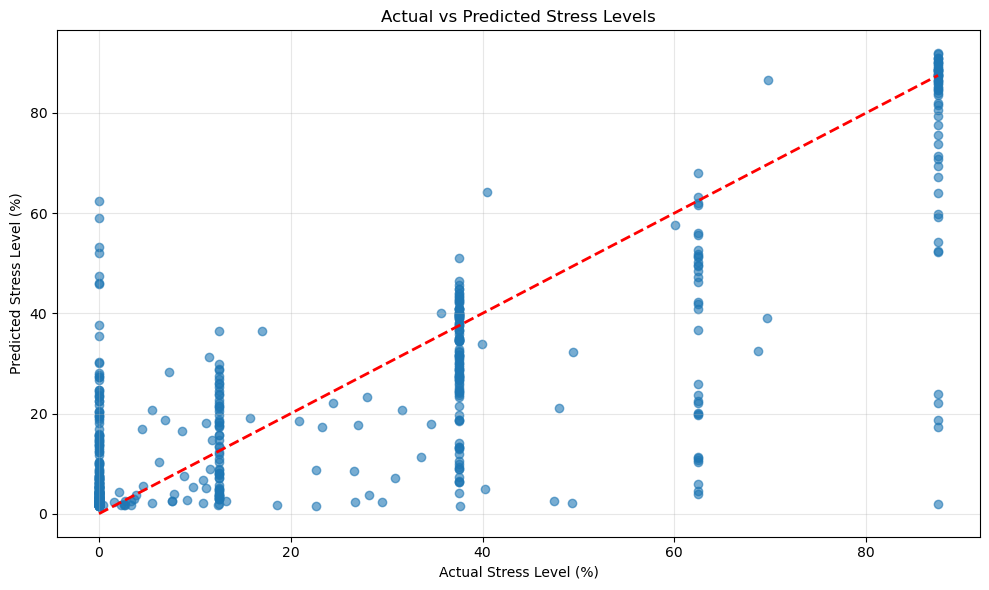

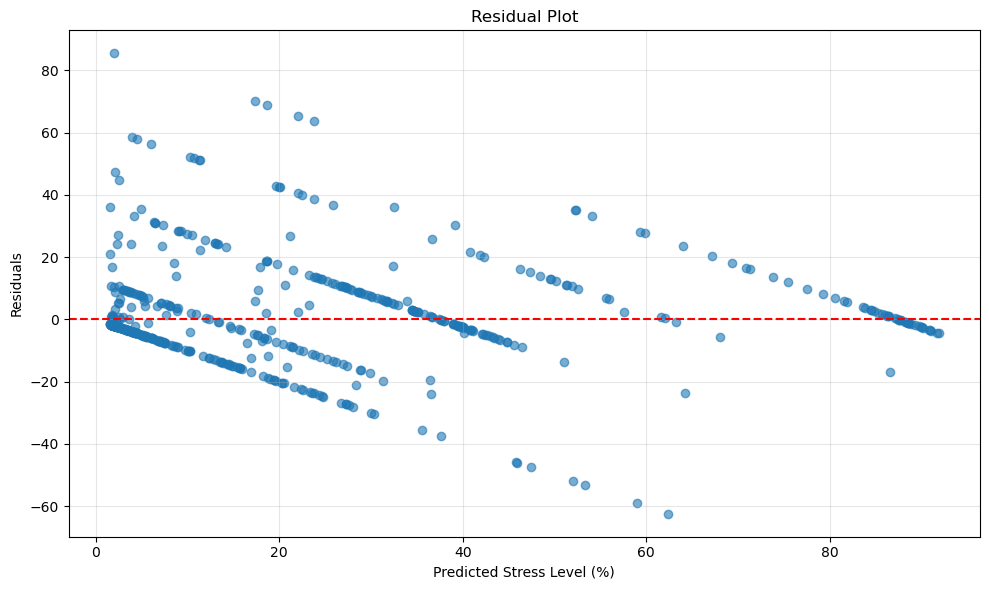

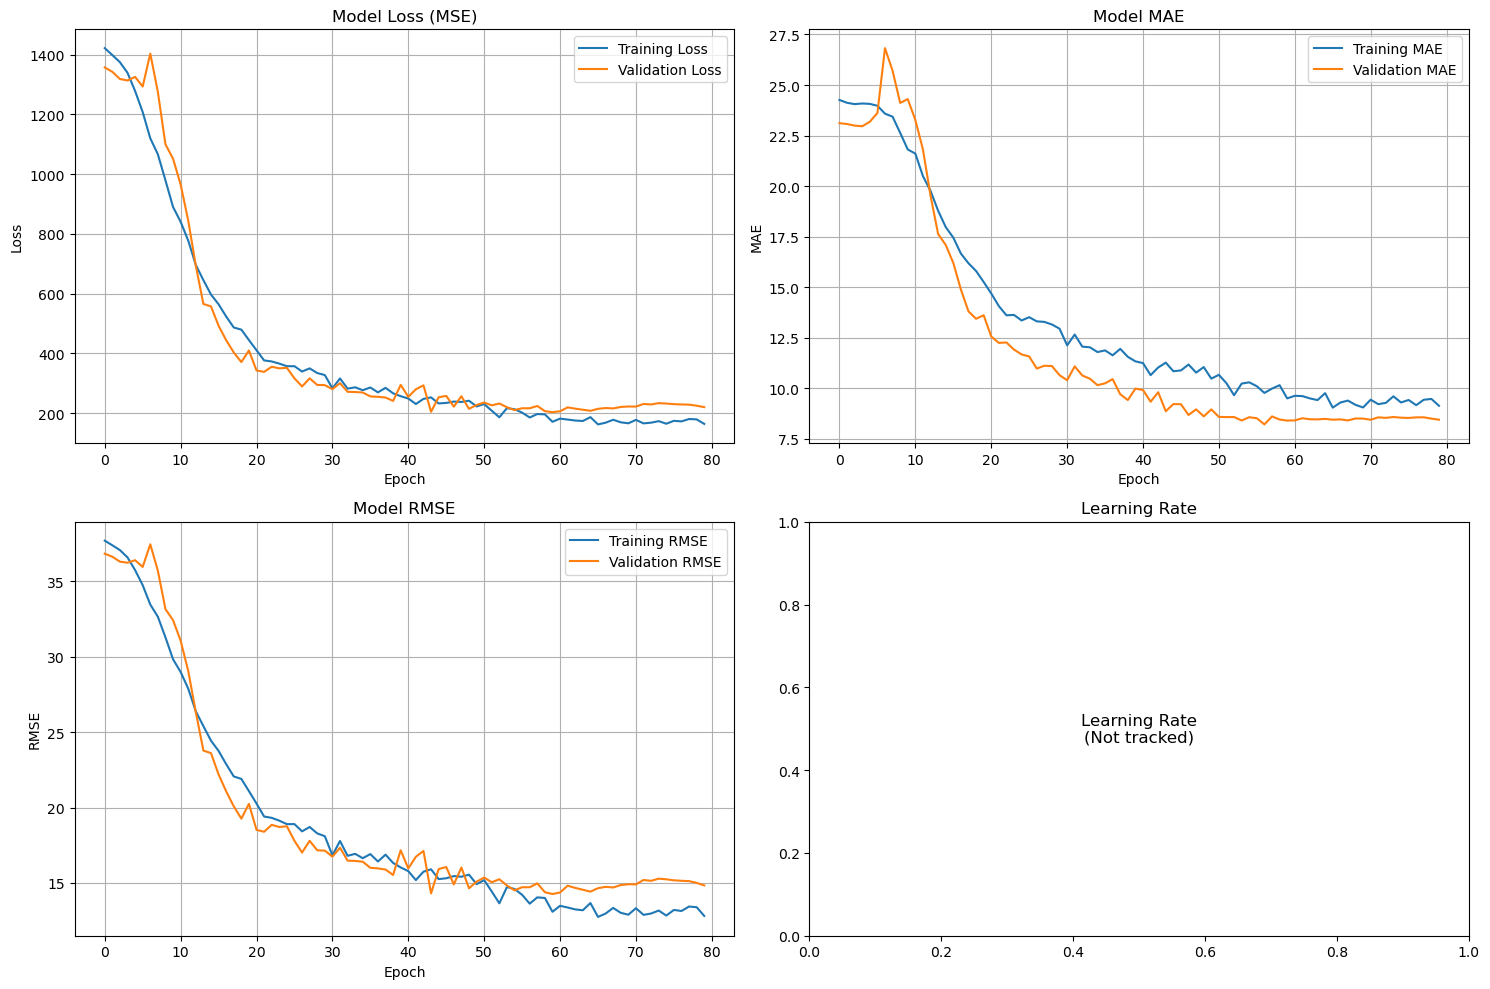

Final model saved as 'final_stress_model.keras'

STRESS LEVEL PREDICTION MODEL SUMMARY
Final Test MSE: 267.6755
Final Test MAE: 10.2907%
Final Test RMSE: 16.3608%
Final Test R² Score: 0.6729


In [19]:
# Plot actual vs predicted stress levels
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Stress Level (%)')
plt.ylabel('Predicted Stress Level (%)')
plt.title('Actual vs Predicted Stress Levels')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('regression_plot.png')
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Stress Level (%)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('residual_plot.png')
plt.show()

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss (MSE)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# MAE plot
axes[0, 1].plot(history.history['mae'], label='Training MAE')
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE')
axes[0, 1].set_title('Model MAE')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True)

# RMSE plot
axes[1, 0].plot(history.history['rmse'], label='Training RMSE')
axes[1, 0].plot(history.history['val_rmse'], label='Validation RMSE')
axes[1, 0].set_title('Model RMSE')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning rate plot (if available)
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], label='Learning Rate')
    axes[1, 1].set_title('Learning Rate')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
else:
    axes[1, 1].text(0.5, 0.5, 'Learning Rate\n(Not tracked)', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].set_title('Learning Rate')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Save the final model
best_model.save('final_stress_model.keras')
print("Final model saved as 'final_stress_model.keras'")

# Print model performance summary
print("\n" + "="*50)
print("STRESS LEVEL PREDICTION MODEL SUMMARY")
print("="*50)
print(f"Final Test MSE: {mse:.4f}")
print(f"Final Test MAE: {mae:.4f}%")
print(f"Final Test RMSE: {rmse:.4f}%")
print(f"Final Test R² Score: {r2:.4f}")
print("="*50)

In [20]:
import os
import joblib
import pickle

# Create a directory for your project files
project_dir = 'StressLevelProject'
if not os.path.exists(project_dir):
    os.makedirs(project_dir)
    print(f"Created directory: {project_dir}")

# Save the model
model_path = os.path.join(project_dir, 'stress_level_model.h5')
best_model.save(model_path)
print(f"Model saved as {model_path}")

# Save preprocessing scaler
scaler_path = os.path.join(project_dir, 'feature_scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"Feature scaler saved as {scaler_path}")

# Save training history
history_path = os.path.join(project_dir, 'training_history.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"Training history saved as {history_path}")

# Save stress level information
stress_info_path = os.path.join(project_dir, 'stress_info.pkl')
stress_info = {
    'stress_range': '0-100%',
    'stress_categories': {
        'Low Stress (0-25%)': 'Meditation',
        'Medium-Low Stress (25-50%)': 'Neutral', 
        'Medium-High Stress (50-75%)': 'Amusement',
        'High Stress (75-100%)': 'Stress'
    },
    'min_stress': float(np.min(y)),
    'max_stress': float(np.max(y)),
    'mean_stress': float(np.mean(y))
}
with open(stress_info_path, 'wb') as f:
    pickle.dump(stress_info, f)
print(f"Stress level information saved as {stress_info_path}")

# Save model summary
summary_path = os.path.join(project_dir, 'model_summary.txt')
model_summary = {
    'input_shape': input_shape,
    'test_mse': f"{mse:.4f}",
    'test_mae': f"{mae:.4f}",
    'test_rmse': f"{rmse:.4f}",
    'test_r2': f"{r2:.4f}",
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'feature_count': X_train.shape[1]
}

with open(summary_path, 'w') as f:
    f.write("STRESS LEVEL PREDICTION MODEL SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    for key, value in model_summary.items():
        f.write(f"{key.replace('_', ' ').title()}: {value}\n")
print(f"Model summary saved as {summary_path}")

# Save evaluation metrics
metrics_path = os.path.join(project_dir, 'evaluation_metrics.txt')
with open(metrics_path, 'w') as f:
    f.write("MODEL EVALUATION METRICS\n")
    f.write("=" * 25 + "\n\n")
    f.write(f"MSE: {mse:.4f}\n")
    f.write(f"MAE: {mae:.4f}%\n")
    f.write(f"RMSE: {rmse:.4f}%\n")
    f.write(f"R² Score: {r2:.4f}\n")
print(f"Evaluation metrics saved as {metrics_path}")

print(f"\nAll files saved successfully to '{project_dir}' directory!")
print("\nFiles created:")
for file in os.listdir(project_dir):
    file_path = os.path.join(project_dir, file)
    if os.path.isfile(file_path):
        file_size = os.path.getsize(file_path)
        print(f"  {file} ({file_size} bytes)")

# Display absolute path to your files
print(f"\nAbsolute path to your project: {os.path.abspath(project_dir)}")

Created directory: StressLevelProject
Model saved as StressLevelProject\stress_level_model.h5
Feature scaler saved as StressLevelProject\feature_scaler.pkl
Training history saved as StressLevelProject\training_history.pkl
Stress level information saved as StressLevelProject\stress_info.pkl
Model summary saved as StressLevelProject\model_summary.txt
Evaluation metrics saved as StressLevelProject\evaluation_metrics.txt

All files saved successfully to 'StressLevelProject' directory!

Files created:
  evaluation_metrics.txt (120 bytes)
  feature_scaler.pkl (1295 bytes)
  model_summary.txt (278 bytes)
  stress_info.pkl (279 bytes)
  stress_level_model.h5 (2738496 bytes)
  training_history.pkl (5152 bytes)

Absolute path to your project: c:\Final Year\PROJECT\COGNITION\PREP\StressLevelProject


## DATA EXPLORATION

In [12]:
# Analyze individual subject stress levels and meditation states
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
import tensorflow as tf
import os

def extract_features(ecg, eda, temp, resp, acc):
    """
    Extract features from physiological signals (same as before)
    """
    features = []
    
    # ECG features
    features.extend([np.mean(ecg), np.std(ecg), np.min(ecg), np.max(ecg)])
    
    # Heart rate variability features
    try:
        # Use a more robust peak detection method
        peaks, _ = signal.find_peaks(ecg, height=np.mean(ecg) + 2*np.std(ecg), distance=100)
        if len(peaks) > 1:
            rr_intervals = np.diff(peaks) / 700  # Convert to seconds (ECG at 700Hz)
            features.extend([np.mean(rr_intervals), np.std(rr_intervals), 
                            np.min(rr_intervals), np.max(rr_intervals)])
        else:
            features.extend([0, 0, 0, 0])
    except:
        features.extend([0, 0, 0, 0])
    
    # EDA features
    features.extend([np.mean(eda), np.std(eda), np.max(eda) - np.min(eda),
                    np.percentile(eda, 25), np.percentile(eda, 75)])
    
    # Temperature features
    features.extend([np.mean(temp), np.std(temp), np.max(temp) - np.min(temp)])
    
    # Respiration features
    try:
        resp_peaks, _ = signal.find_peaks(resp, height=np.mean(resp) + 0.5*np.std(resp), distance=100)
        breathing_rate = len(resp_peaks) / (len(resp) / 700)  # Breaths per minute (resp at 700Hz)
        features.extend([np.mean(resp), np.std(resp), breathing_rate])
    except:
        features.extend([np.mean(resp), np.std(resp), 0])
    
    # Accelerometer features (magnitude and separate axes)
    acc_magnitude = np.linalg.norm(acc, axis=1)
    features.extend([np.mean(acc_magnitude), np.std(acc_magnitude),
                    np.percentile(acc_magnitude, 25), np.percentile(acc_magnitude, 75)])
    
    # Add features for each accelerometer axis
    for axis in range(3):
        features.extend([np.mean(acc[:, axis]), np.std(acc[:, axis])])
    
    return features

In [13]:
def analyze_subject_stress_levels(subject_id, dataset_path, model, scaler):
    """
    Analyze stress levels for a specific subject including meditation states
    """
    subject_path = os.path.join(dataset_path, subject_id)
    
    # Read the data from .pkl file
    import pickle
    with open(os.path.join(subject_path, f'{subject_id}.pkl'), 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    # Extract signals and labels
    signals = data['signal']
    labels = data['label']
    
    # Create time array (assuming 700Hz sampling rate)
    time_minutes = np.arange(len(labels)) / (700 * 60)  # Convert to minutes
    
    # Extract relevant signals from chest sensor
    chest_data = signals['chest']
    
    # Get ECG data - 700Hz
    ecg = chest_data['ECG']
    eda = chest_data['EDA']
    temperature = chest_data['Temp']
    resp = chest_data['Resp']
    acc = chest_data['ACC']
    
    # Create feature matrix using sliding windows
    window_size_seconds = 60
    sampling_rate = 700
    window_size = window_size_seconds * sampling_rate
    step_size = window_size // 2  # 50% overlap
    
    stress_predictions = []
    time_points = []
    actual_labels = []
    
    for i in range(0, len(ecg) - window_size, step_size):
        # Extract window for each signal
        ecg_window = ecg[i:i+window_size]
        eda_window = eda[i:i+window_size]
        temp_window = temperature[i:i+window_size]
        resp_window = resp[i:i+window_size]
        acc_window = acc[i:i+window_size]
        
        # Extract features
        features = extract_features(ecg_window, eda_window, temp_window, resp_window, acc_window)
        
        # Scale features
        features_scaled = scaler.transform([features])
        
        # Reshape for model
        features_reshaped = features_scaled.reshape(1, features_scaled.shape[1], 1)
        
        # Predict stress level
        stress_level = model.predict(features_reshaped, verbose=0)[0][0]
        
        stress_predictions.append(stress_level)
        time_points.append(time_minutes[i + window_size//2])  # Middle of window
        actual_labels.append(labels[i + window_size//2])
    
    return np.array(stress_predictions), np.array(time_points), np.array(actual_labels)

In [16]:
def plot_subject_analysis(subject_id, stress_levels, time_points, actual_labels):
    """
    Plot comprehensive analysis for a subject
    """
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Stress level over time
    ax1.plot(time_points, stress_levels, 'b-', alpha=0.7, linewidth=2)
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('Predicted Stress Level (%)')
    ax1.set_title(f'Subject {subject_id} - Stress Level Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 100)
    
    # Add horizontal lines for stress categories
    ax1.axhline(y=25, color='green', linestyle='--', alpha=0.5, label='Low Stress')
    ax1.axhline(y=50, color='yellow', linestyle='--', alpha=0.5, label='Medium-Low')
    ax1.axhline(y=75, color='orange', linestyle='--', alpha=0.5, label='Medium-High')
    ax1.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='High Stress')
    ax1.legend()
    
    # Plot 2: Actual labels vs predicted stress
    colors = ['green', 'red', 'blue', 'purple']  # Meditation, Stress, Amusement, Neutral
    label_names = ['Meditation', 'Stress', 'Amusement', 'Neutral']
    
    for label_val in [4, 2, 3, 1]:  # Meditation, Stress, Amusement, Neutral
        mask = actual_labels == label_val
        if np.any(mask):
            color = colors[label_val-1] if label_val <= 4 else 'gray'
            label_name = label_names[label_val-1] if label_val <= 4 else f'Label {label_val}'
            ax2.scatter(time_points[mask], stress_levels[mask], 
                       c=color, alpha=0.6, label=label_name)
    
    ax2.set_xlabel('Time (minutes)')
    ax2.set_ylabel('Predicted Stress Level (%)')
    ax2.set_title(f'Subject {subject_id} - Stress Level by Activity')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    
    # Plot 3: Distribution of stress levels by activity
    stress_by_activity = []
    activity_names = []
    
    for label_val, activity_name in zip([4, 1, 3, 2], ['Meditation', 'Neutral', 'Amusement', 'Stress']):
        mask = actual_labels == label_val
        if np.any(mask):
            stress_by_activity.append(stress_levels[mask])
            activity_names.append(activity_name)
    
    ax3.boxplot(stress_by_activity, labels=activity_names)
    ax3.set_ylabel('Predicted Stress Level (%)')
    ax3.set_title(f'Subject {subject_id} - Stress Distribution by Activity')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Stress level statistics by activity
    activity_stats = []
    for label_val, activity_name in zip([4, 1, 3, 2], ['Meditation', 'Neutral', 'Amusement', 'Stress']):
        mask = actual_labels == label_val
        if np.any(mask):
            activity_stress = stress_levels[mask]
            activity_stats.append({
                'Activity': activity_name,
                'Mean': np.mean(activity_stress),
                'Std': np.std(activity_stress),
                'Min': np.min(activity_stress),
                'Max': np.max(activity_stress)
            })
    
    stats_df = pd.DataFrame(activity_stats)
    if not stats_df.empty:
        ax4.axis('off')
        table = ax4.table(cellText=stats_df.round(2).values,
                         rowLabels=stats_df.index,
                         colLabels=stats_df.columns,
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        ax4.set_title(f'Subject {subject_id} - Stress Statistics by Activity')
    
    plt.tight_layout()
    plt.savefig(f'subject_{subject_id}_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return stats_df

In [15]:
def analyze_meditation_effectiveness(subject_id, stress_levels, actual_labels):
    """
    Analyze meditation effectiveness by comparing stress levels before/during/after meditation
    """
    # Find meditation periods
    meditation_indices = np.where(actual_labels == 4)[0]
    
    if len(meditation_indices) == 0:
        print(f"No meditation data found for subject {subject_id}")
        return None
    
    # Find continuous meditation blocks
    meditation_blocks = []
    current_block = []
    
    for i in range(len(meditation_indices)):
        if i == 0 or meditation_indices[i] == meditation_indices[i-1] + 1:
            current_block.append(meditation_indices[i])
        else:
            if len(current_block) >= 5:  # Minimum block size
                meditation_blocks.append(current_block)
            current_block = [meditation_indices[i]]
    
    if current_block and len(current_block) >= 5:
        meditation_blocks.append(current_block)
    
    print(f"Found {len(meditation_blocks)} meditation blocks for subject {subject_id}")
    
    # Analyze each meditation block
    meditation_results = []
    
    for block_idx, block in enumerate(meditation_blocks):
        if len(block) < 10:  # Skip very short blocks
            continue
            
        # Get stress levels before meditation (2 minutes before)
        before_start = max(0, block[0] - 20)  # 20 time points ≈ 2 minutes
        before_stress = stress_levels[before_start:block[0]]
        
        # Get stress levels during meditation
        during_stress = stress_levels[block]
        
        # Get stress levels after meditation (2 minutes after)
        after_end = min(len(stress_levels), block[-1] + 20)
        after_stress = stress_levels[block[-1]:after_end]
        
        if len(before_stress) > 0 and len(during_stress) > 0 and len(after_stress) > 0:
            meditation_results.append({
                'block': block_idx + 1,
                'before_mean': np.mean(before_stress),
                'during_mean': np.mean(during_stress),
                'after_mean': np.mean(after_stress),
                'stress_reduction': np.mean(before_stress) - np.mean(during_stress),
                'block_duration': len(block)
            })
    
    if meditation_results:
        results_df = pd.DataFrame(meditation_results)
        
        # Plot meditation effectiveness
        plt.figure(figsize=(12, 6))
        
        # Plot stress levels around meditation
        for i, result in enumerate(meditation_results):
            plt.subplot(1, len(meditation_results), i+1)
            times = ['Before', 'During', 'After']
            values = [result['before_mean'], result['during_mean'], result['after_mean']]
            colors = ['red', 'green', 'blue']
            
            bars = plt.bar(times, values, color=colors, alpha=0.7)
            plt.ylabel('Stress Level (%)')
            plt.title(f'Meditation Block {result["block"]}\nReduction: {result["stress_reduction"]:.1f}%')
            plt.ylim(0, 100)
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                        f'{value:.1f}%', ha='center', va='bottom')
        
        plt.suptitle(f'Subject {subject_id} - Meditation Effectiveness Analysis')
        plt.tight_layout()
        plt.savefig(f'meditation_analysis_{subject_id}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return results_df
    else:
        print("No valid meditation blocks found for analysis")
        return None

In [17]:
# Load the trained model and scaler
print("Loading trained model and scaler...")
try:
    model = tf.keras.models.load_model('final_stress_model.keras')
    scaler = joblib.load('stress_scaler.pkl')
    print("Model and scaler loaded successfully!")
except:
    print("Error loading model or scaler. Please make sure they exist.")
    model = None
    scaler = None

# Set dataset path
dataset_path = r'C:\Users\vijay\Downloads\Stress\WESAD'

# Define subjects to analyze
subjects_to_analyze = ['S2', 'S3', 'S4']  # You can add more subjects

print(f"Subjects to analyze: {subjects_to_analyze}")

Loading trained model and scaler...
Model and scaler loaded successfully!
Subjects to analyze: ['S2', 'S3', 'S4']



Analyzing Subject: S2


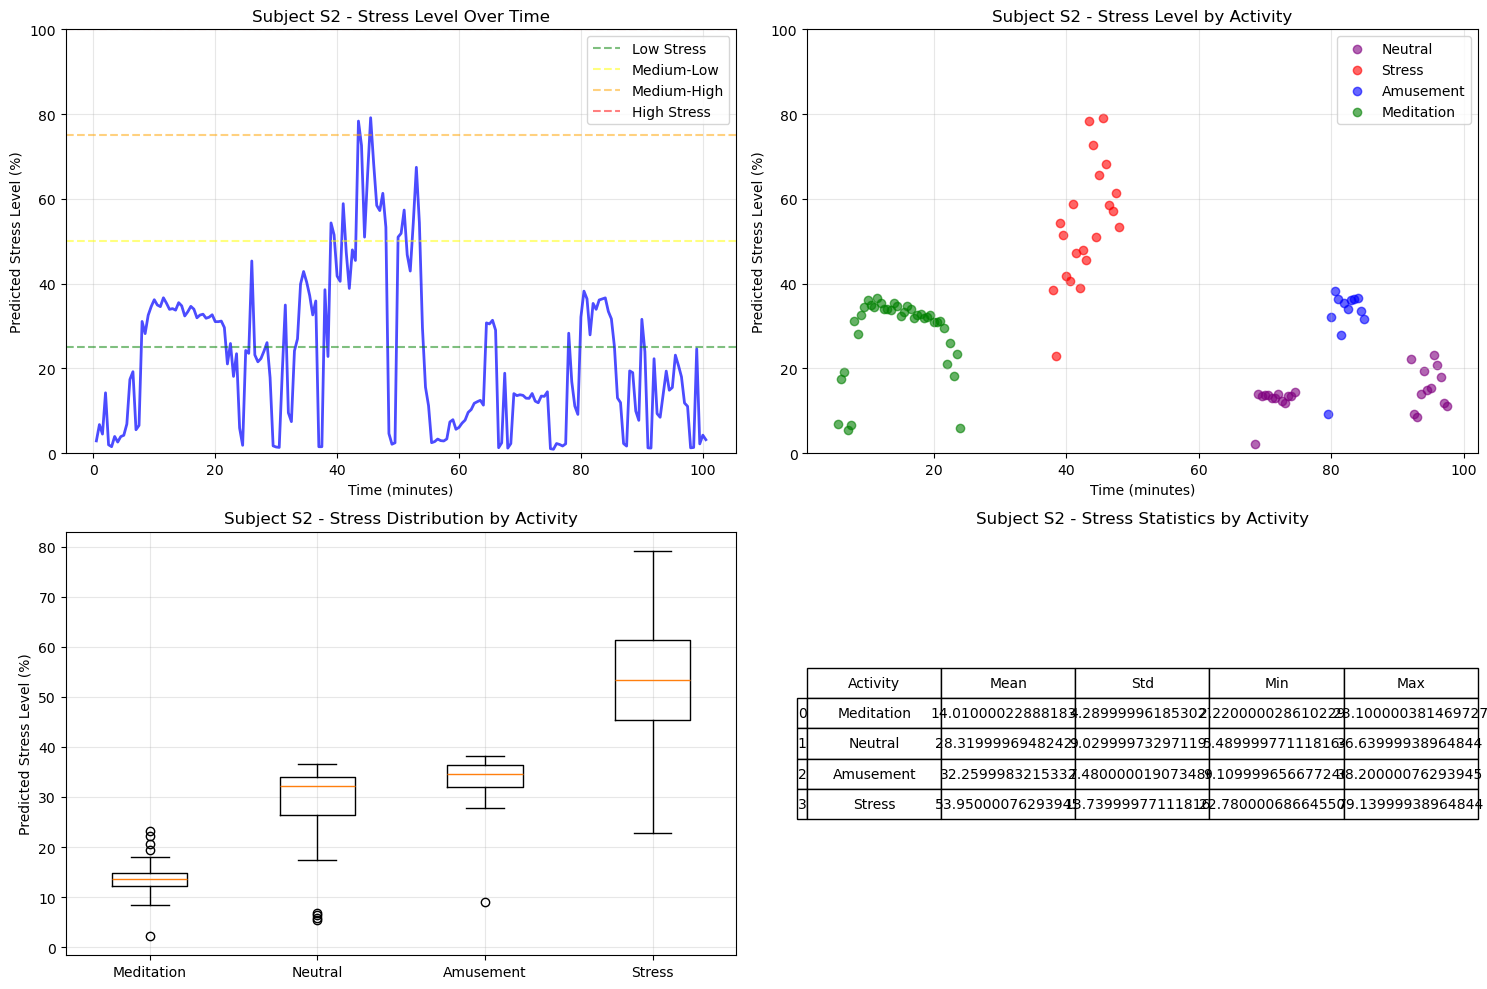

Found 2 meditation blocks for subject S2


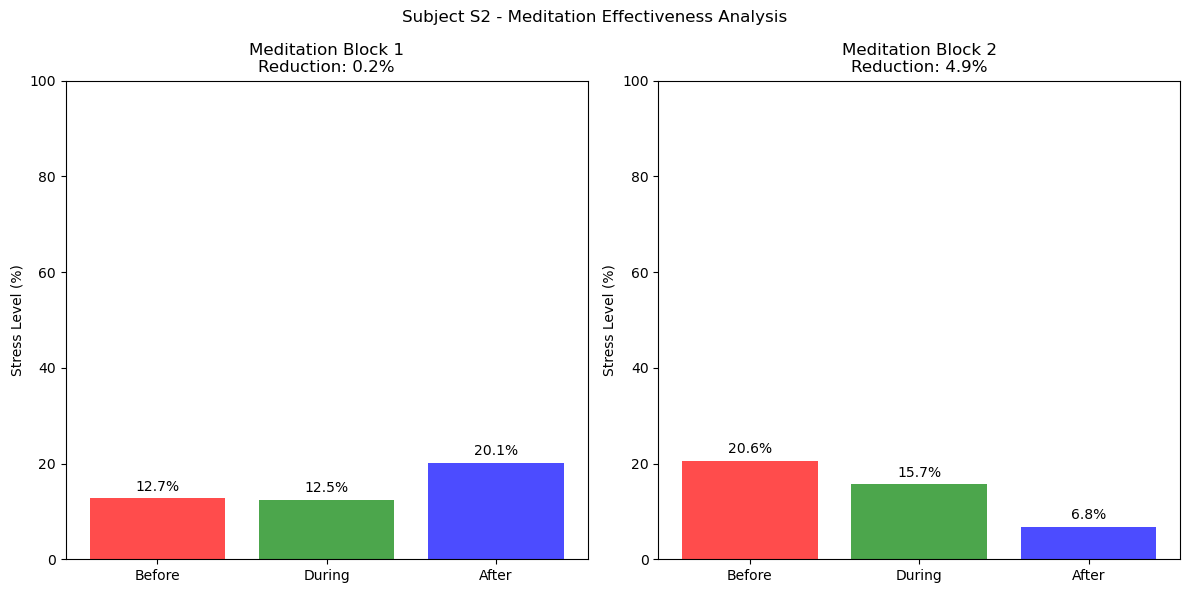


Subject S2 Summary:
Total time analyzed: 100.5 minutes
Average stress level: 23.0%
Stress level range: 0.9% - 79.1%

Activity distribution:
  Unknown(0): 101 samples (50.2%)
  Neutral: 38 samples (18.9%)
  Stress: 21 samples (10.4%)
  Amusement: 12 samples (6.0%)
  Meditation: 25 samples (12.4%)
  Unknown(6): 2 samples (1.0%)
  Unknown(7): 2 samples (1.0%)

Analyzing Subject: S3


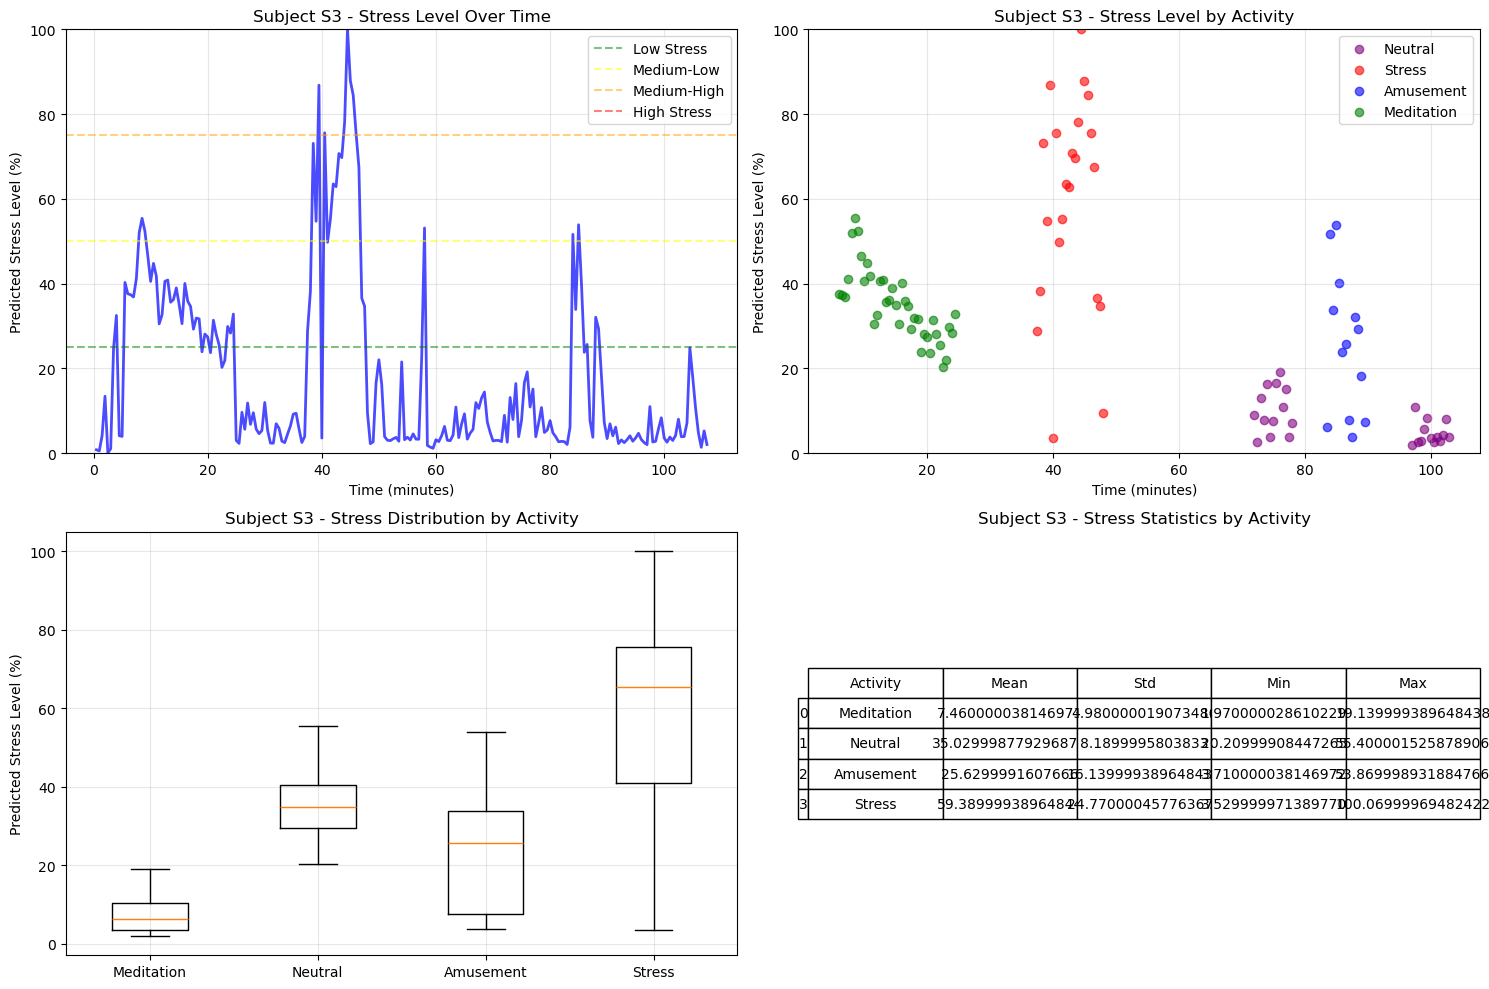

Found 2 meditation blocks for subject S3


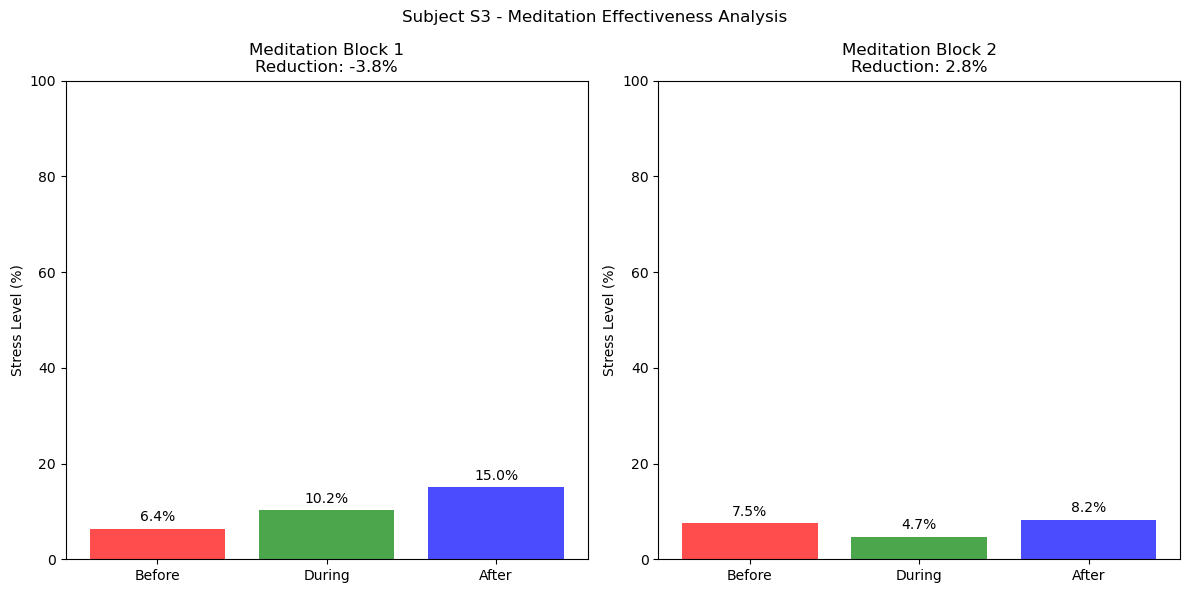


Subject S3 Summary:
Total time analyzed: 107.5 minutes
Average stress level: 18.4%
Stress level range: 0.0% - 100.1%

Activity distribution:
  Unknown(0): 109 samples (50.7%)
  Neutral: 38 samples (17.7%)
  Stress: 22 samples (10.2%)
  Amusement: 13 samples (6.0%)
  Meditation: 26 samples (12.1%)
  Unknown(5): 2 samples (0.9%)
  Unknown(6): 2 samples (0.9%)
  Unknown(7): 3 samples (1.4%)

Analyzing Subject: S4


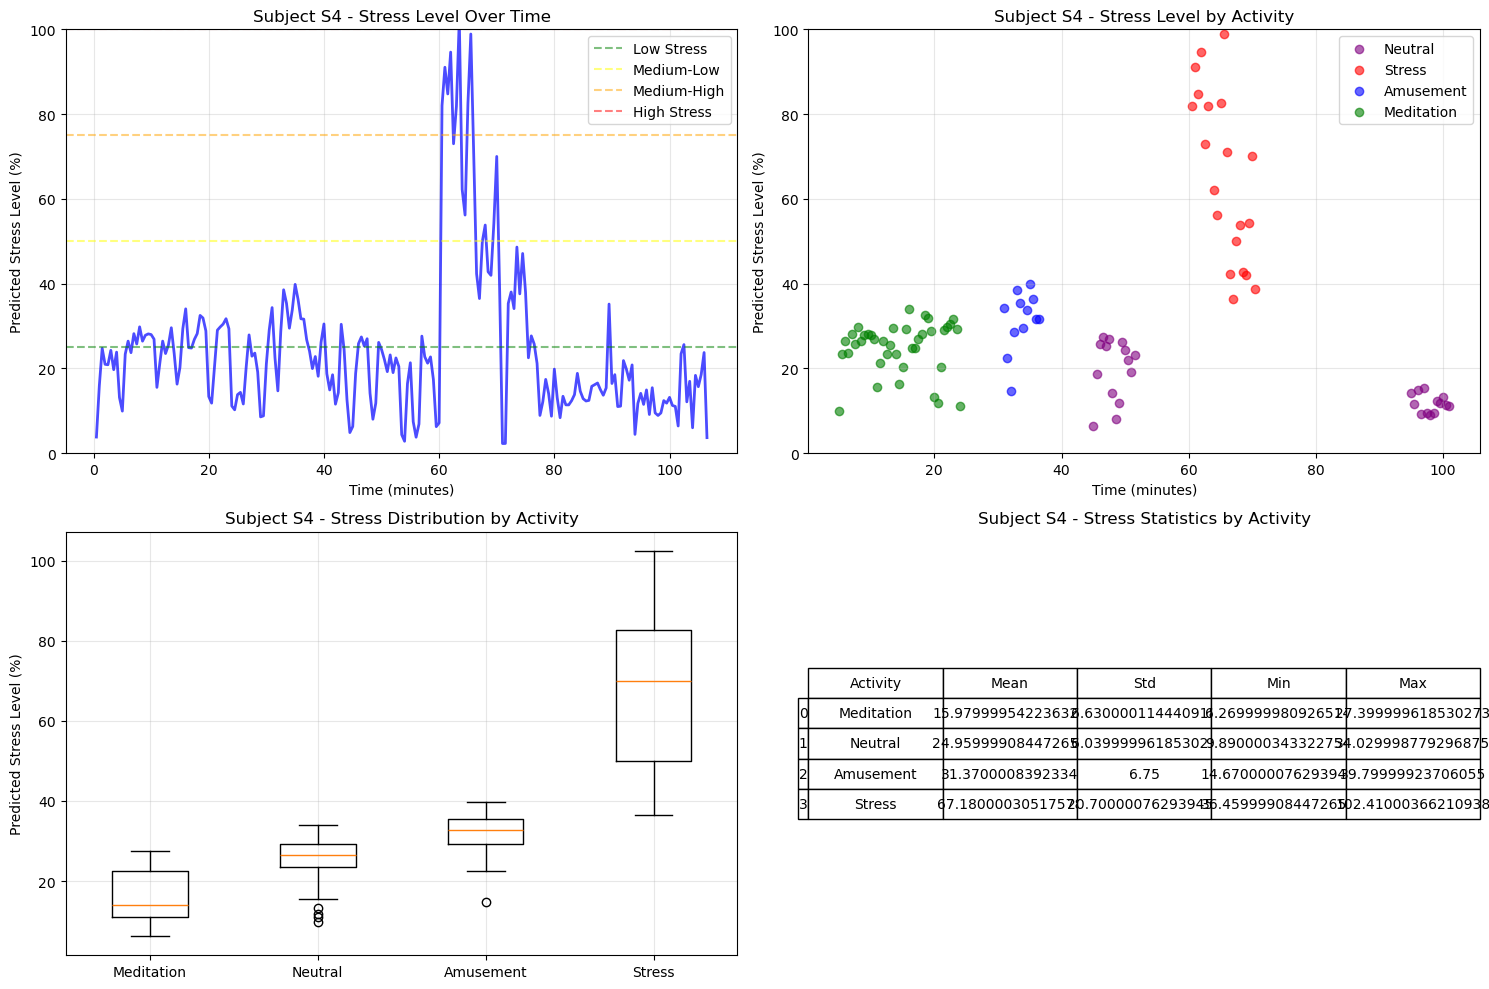

Found 2 meditation blocks for subject S4


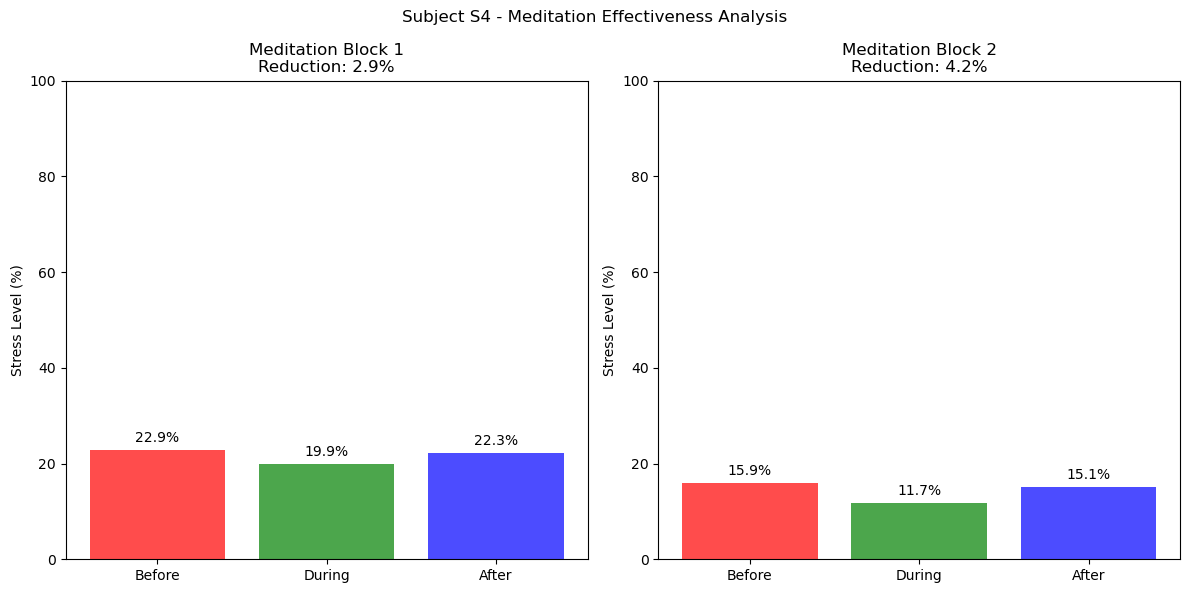


Subject S4 Summary:
Total time analyzed: 106.5 minutes
Average stress level: 24.5%
Stress level range: 2.2% - 102.4%

Activity distribution:
  Unknown(0): 108 samples (50.7%)
  Neutral: 39 samples (18.3%)
  Stress: 21 samples (9.9%)
  Amusement: 12 samples (5.6%)
  Meditation: 27 samples (12.7%)
  Unknown(5): 2 samples (0.9%)
  Unknown(6): 2 samples (0.9%)
  Unknown(7): 2 samples (0.9%)

Individual subject statistics saved to 'individual_subject_stats.csv'


In [18]:
# Analyze individual subjects
if model is not None and scaler is not None:
    all_subject_stats = []
    
    for subject_id in subjects_to_analyze:
        try:
            print(f"\n{'='*50}")
            print(f"Analyzing Subject: {subject_id}")
            print(f"{'='*50}")
            
            # Analyze subject data
            stress_levels, time_points, actual_labels = analyze_subject_stress_levels(
                subject_id, dataset_path, model, scaler)
            
            if len(stress_levels) > 0:
                # Plot comprehensive analysis
                stats_df = plot_subject_analysis(subject_id, stress_levels, time_points, actual_labels)
                
                # Analyze meditation effectiveness
                meditation_results = analyze_meditation_effectiveness(subject_id, stress_levels, actual_labels)
                
                # Print summary statistics
                print(f"\nSubject {subject_id} Summary:")
                print(f"Total time analyzed: {time_points[-1]:.1f} minutes")
                print(f"Average stress level: {np.mean(stress_levels):.1f}%")
                print(f"Stress level range: {np.min(stress_levels):.1f}% - {np.max(stress_levels):.1f}%")
                
                # Count activities
                unique_labels, counts = np.unique(actual_labels, return_counts=True)
                label_names = {1: 'Neutral', 2: 'Stress', 3: 'Amusement', 4: 'Meditation'}
                
                print("\nActivity distribution:")
                for label_val, count in zip(unique_labels, counts):
                    activity_name = label_names.get(label_val, f'Unknown({label_val})')
                    percentage = (count / len(actual_labels)) * 100
                    print(f"  {activity_name}: {count} samples ({percentage:.1f}%)")
                
                # Store statistics for comparison
                if stats_df is not None:
                    stats_df['Subject'] = subject_id
                    all_subject_stats.append(stats_df)
                
            else:
                print(f"No data could be processed for subject {subject_id}")
                
        except Exception as e:
            print(f"Error analyzing subject {subject_id}: {e}")
    
    # Store the results for cross-subject comparison
    if all_subject_stats:
        # Save individual subject statistics
        individual_stats = pd.concat(all_subject_stats, ignore_index=True)
        individual_stats.to_csv('individual_subject_stats.csv', index=False)
        print("\nIndividual subject statistics saved to 'individual_subject_stats.csv'")
else:
    print("Cannot proceed with analysis. Model or scaler not available.")